In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from simtk import unit
from simtk import openmm as omm
from simtk.openmm import app
import molsysmt as msm
from tqdm import tqdm

# Alanine dipeptide in explicit solvent

## With OpenMM from scratch

In [3]:
from molecular_systems import files
pdbfile_path = files.alanine_dipeptide['octahedral_14.pdb']

In [4]:
msm.info(pdbfile_path)

form,n_atoms,n_groups,n_components,n_chains,n_molecules,n_entities,n_waters,n_peptides,n_frames
pdb,4333,1440,1438,1,1438,2,1437,1,1


In [5]:
view = msm.view(pdbfile_path, surface=True)
view

NGLWidget()

In [6]:
temperature = 300.0*unit.kelvin
collisions_rate = 1.0/unit.picoseconds
total_time = 50.0*unit.picoseconds
saving_timestep = 1.0*unit.picoseconds
integration_timestep = 2.0*unit.femtoseconds

steps_per_cicle = round(saving_timestep/integration_timestep)
n_steps = round(total_time/integration_timestep)
n_cicles = round(n_steps/steps_per_cicle)

pdbfile = app.PDBFile(pdbfile_path)

topology = pdbfile.topology
positions = pdbfile.positions

forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')

system = forcefield.createSystem(topology,
                                 nonbondedMethod=app.PME, nonbondedCutoff=9.0*unit.angstroms,
                                 switchDistance=7.5*unit.angstroms,
                                 rigidWater=True, constraints=app.HBonds, hydrogenMass=None)

forces = {ii.__class__.__name__ : ii for ii in system.getForces()}
forces['NonbondedForce'].setUseDispersionCorrection(True)
forces['NonbondedForce'].setEwaldErrorTolerance(1.0e-5)

integrator = omm.LangevinIntegrator(temperature, collisions_rate, integration_timestep)
integrator.setConstraintTolerance(0.00001)

platform = omm.Platform.getPlatformByName('CUDA')
simulation_properties = {}
simulation_properties['CudaPrecision']='mixed'

# Context.

context = omm.Context(system, integrator, platform, simulation_properties)
context.setPositions(positions)

# Energy Minimization
Potential_Energy = context.getState(getEnergy=True).getPotentialEnergy()
print('Before energy minimization: {}'.format(Potential_Energy))
omm.LocalEnergyMinimizer_minimize(context)
Potential_Energy = context.getState(getEnergy=True).getPotentialEnergy()
print('After energy minimization: {}'.format(Potential_Energy))

Before energy minimization: -17415.342173066165 kJ/mol
After energy minimization: -70224.23182850215 kJ/mol


In [7]:
# Initial velocities
n_atoms = topology.getNumAtoms()
velocities = np.zeros([n_atoms, 3], np.float32) * unit.nanometers/unit.picosecond
context.setVelocities(velocities)

# Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

time = np.zeros([n_cicles], np.float32) * unit.picoseconds
trajectory = np.zeros([n_cicles, n_atoms, 3], np.float32) * unit.nanometers
velocity = np.zeros([n_cicles, n_atoms, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole

# Initial context in reporters

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
time[0] = state.getTime()
trajectory[0] = state.getPositions()
velocity[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Integration loop saving every cicle steps

for ii in tqdm(range(1, n_cicles)):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[ii] = state.getTime()
    trajectory[ii] = state.getPositions()
    velocity[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

100%|██████████| 49/49 [05:04<00:00,  6.21s/it]


In [8]:
trajectory.shape

(50, 4333, 3)

In [9]:
print('The trajectory occupies {} gigabytes.'.format(trajectory.nbytes / 1024**3))

The trajectory occupies 0.002421252429485321 gigabytes.


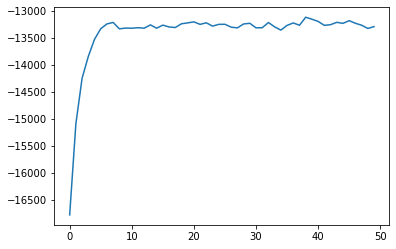

In [10]:
plt.plot(time, potential_energy)
plt.show()

In [11]:
_, _, phi_values, psi_values = msm.ramachandran_angles([topology, trajectory])

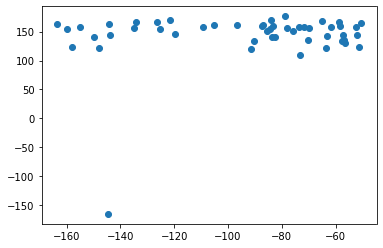

In [12]:
plt.scatter(phi_values, psi_values)
plt.show()

## With MolSysMT 

## With this library

In [13]:
from molecular_systems import AlanineDipeptideExplicitSolvent
from molecular_systems.tools.md import langevin_NVT, energy_minimization

In [14]:
dialanine=AlanineDipeptideExplicitSolvent(forcefield='AMBER14')

energy_minimization(dialanine)
time, trajectory, velocity, kin_energy, pot_energy = langevin_NVT(dialanine,
                                                                  temperature = 300 * unit.kelvin,
                                                                  friction = 1.0 / unit.picoseconds,
                                                                  saving_timestep = 1.0 * unit.picoseconds,
                                                                  total_time = 50.0 * unit.picoseconds)

Potential energy before minimization: -17415.52575900621 kJ/mol
Potential energy after minimization: -70408.30700900621 kJ/mol


100%|██████████| 49/49 [04:02<00:00,  4.95s/it]


In [15]:
_, _, phi_values, psi_values = msm.ramachandran_angles([dialanine.topology, trajectory])

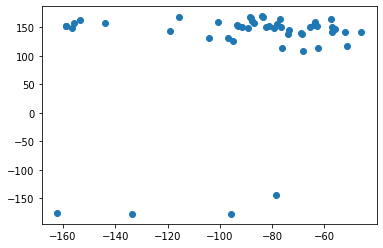

In [16]:
plt.scatter(phi_values, psi_values)

In [17]:
view = msm.view([dialanine.topology, trajectory], surface=False)
view

NGLWidget(max_frame=49)